In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from utils.customloader import CustomDataset, DatasetSplit
from utils.separate_into_classes import separate_into_classes
#from utils.arguments import Args
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar
from models.Fed import FedAvg
from models.test import test_img
from utils.smooth_crossentropy import SmoothCrossEntropyLoss
from utils.dataloader import get_dataloader, set_seed
from utils.train_glob import train_global_model, test_model
import random
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import copy
from sklearn.model_selection import train_test_split



import torch
class Args:
    #federated arugments
    epochs=5
    num_users=10
    local_ep=1
    local_bs=10
    bs=128
    lr=0.01
    momentum=0.5
    split='user'
    
    
    #model arguments
    model='mnist'
    kernel_num=9
    kernel_sizes='3,4,5'
    norm='batch_norm'
    num_filters=32
    max_pool=True
    
    #other arguments
    #data='mnist'
    #iid='store_true'
    num_channels=1
    num_classes=10
    #stopping_rounds=10
    verbose='store_true'
    seed=1
    #all_clients='store_true'
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cpu')
    
    

args = Args()    
##############SET SEEDS FOR REPRODUCIBILITY#############
np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)
# if you are suing GPU
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)


torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True    
##############~SET SEEDS FOR REPRODUCIBILITY#############

In [2]:
global_train_loader, local_train_loader, test_loader = get_dataloader(data='mnist', 
                                                                      test_size=0.5, 
                                                                      num_workers=2,
                                                                      batch_size=128, 
                                                                      seed=args.seed,
                                                                     )

net_glob = CNNMnist(args=args).to(args.device)
net_glob.train()

optimizer = optim.SGD(net_glob.parameters(), lr=args.lr, momentum=args.momentum)
sloss = F.cross_entropy













(30000, 1, 28, 28)
torch.Size([30000])
(30000, 1, 28, 28)
torch.Size([30000])


(30000, 1, 28, 28)
(30000, 28, 28)


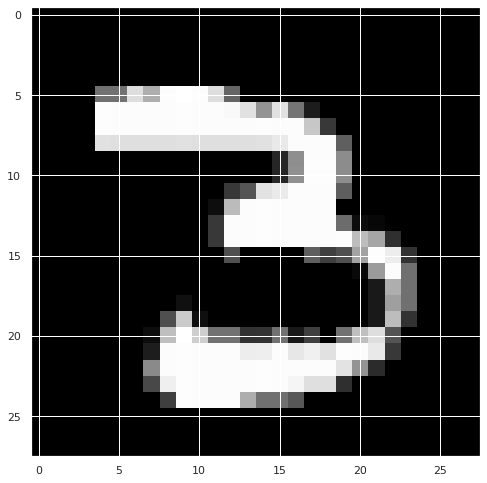

In [609]:
from sklearn.manifold import TSNE
import seaborn as sns
palette = sns.color_palette("bright", 10)
sns.set(rc={'figure.figsize':(16.7,8.27)})

data_train = global_train_loader.dataset.data
label_train = global_train_loader.dataset.targets

print(data_train.shape)
data_train = np.squeeze(np.transpose(data_train, (0, 2, 3, 1)))
print(data_train.shape)
plt.imshow(data_train[0], cmap='gray')

In [750]:
#X, y = load_digits(return_X_y=True)

X, y = data_train, label_train
y = np.array(y)

In [518]:
X=X[0:30000]
y=y[0:30000]

print(X.shape)
X = np.reshape(X, (X.shape[0], 28*28))
print(X.shape)

(30000, 28, 28)
(30000, 784)


In [519]:
tsne = TSNE(n_jobs=-1, verbose=2)
X_embedded = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 13.881s...
[t-SNE] Computed neighbors for 30000 samples in 277.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for 

In [524]:
checkpoint_X_embedded = copy.deepcopy(X_embedded)

In [771]:
x_min = min(X_embedded[:,0]) - 5
x_max = max(X_embedded[:,0]) + 5

y_min = min(X_embedded[:,1]) - 5
y_max = max(X_embedded[:,1]) + 5

[(-79.20205688476562, 71.37166595458984)]

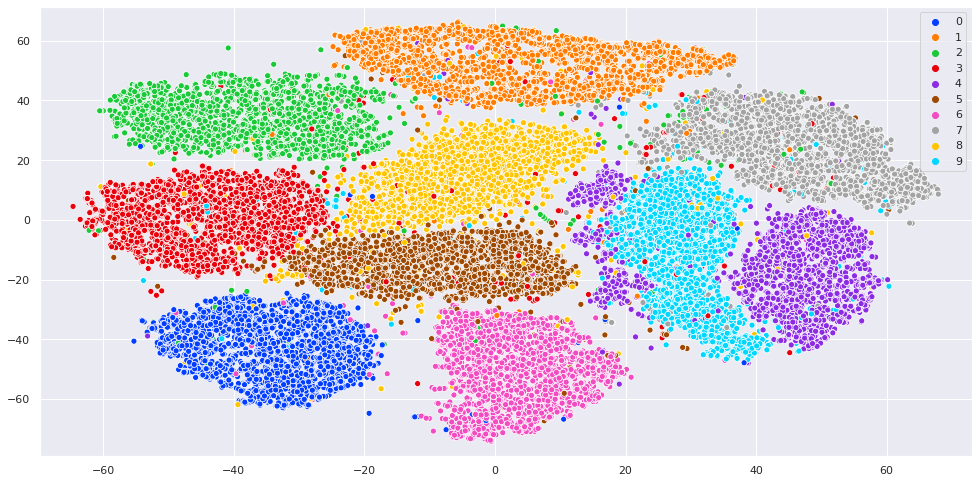

In [772]:
g = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
g.set(xlim=(x_min, x_max))
g.set(ylim=(y_min, y_max))

# 1. Same labels, different features

In [784]:
#Define which labels you want to find
find = [1]


ix = np.in1d(y.ravel(), find).reshape(y.shape)
indexes = np.argwhere(ix==True)

X_Re = np.reshape(X, (X.shape[0], 28, 28))
images = [X_Re[i] for i in indexes]
labels = np.squeeze([y[i] for i in indexes])
X_embedded_re = [X_embedded[i] for i in indexes]
X_embedded_re = np.concatenate(X_embedded_re, axis=0)


[(-79.20205688476562, 71.37166595458984)]

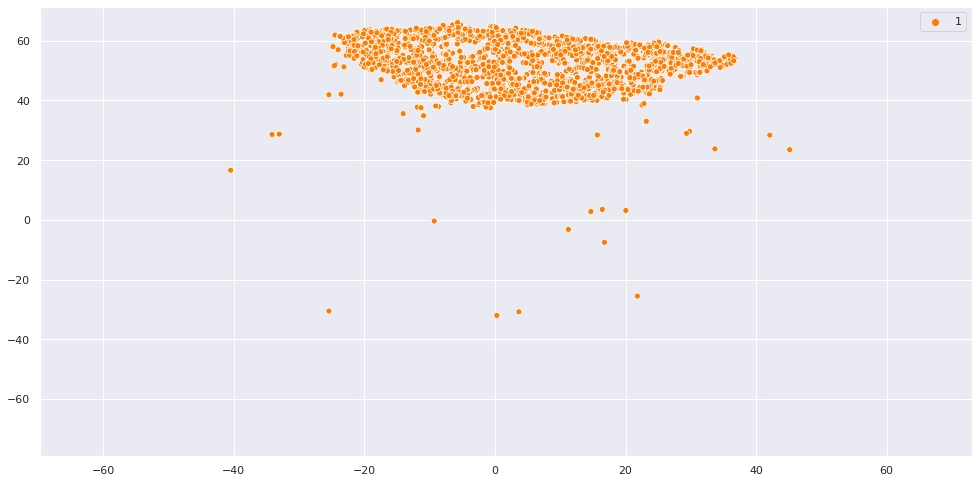

In [785]:
labels_unique = np.unique(labels)
palettes = [palette[i] for i in labels_unique]

g = sns.scatterplot(X_embedded_re[:,0], X_embedded_re[:,1], hue=labels, legend='full', palette=palettes)
g.set(xlim=(x_min, x_max))
g.set(ylim=(y_min, y_max))

## 1a. Erase outliers

In [786]:
max_deviations = 2


mean_x = np.mean(X_embedded_re[:,0])
standard_deviation_x = np.std(X_embedded_re[:, 0])
distance_from_mean_x = abs(X_embedded_re[:, 0] - mean_x)
not_outlier_x = distance_from_mean_x < max_deviations * standard_deviation_x
indexes_x = np.argwhere(not_outlier_x==True)


mean_y = np.mean(X_embedded_re[:,1])
standard_deviation_y = np.std(X_embedded_re[:, 1])
distance_from_mean_y = abs(X_embedded_re[:, 1] - mean_y)
not_outlier_y = distance_from_mean_y < max_deviations * standard_deviation_y
indexes_y = np.argwhere(not_outlier_y==True)


indexes = np.intersect1d(indexes_x, indexes_y)

In [787]:
labels2 = np.squeeze([labels[i] for i in indexes])
X_embedded_re2 = [X_embedded_re[i] for i in indexes]
X_embedded_re2 = np.concatenate(X_embedded_re2, axis=0)
X_embedded_re2 = np.reshape(X_embedded_re2, (X_embedded_re2.shape[0] // 2, 2))

labels_unique = np.unique(labels)
palettes = [palette[i] for i in labels_unique]

[(-79.20205688476562, 71.37166595458984)]

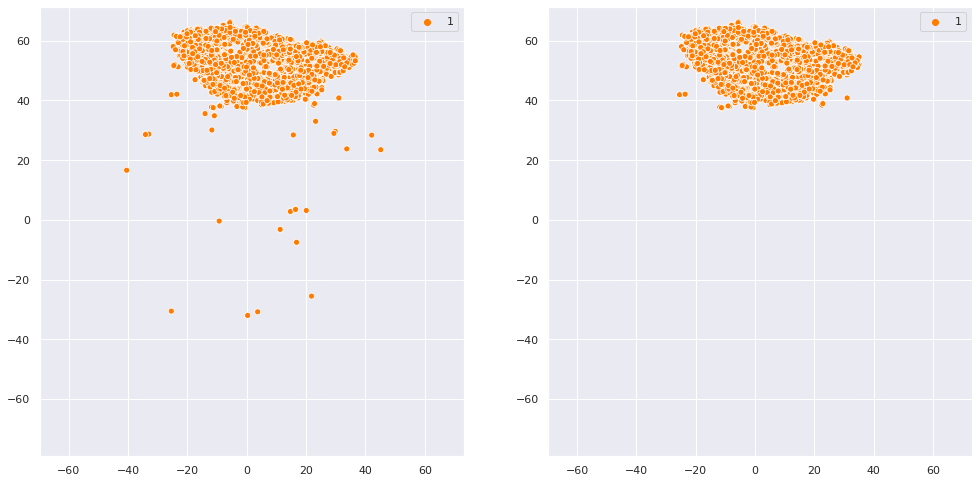

In [788]:
fig, axs = plt.subplots(ncols=2, )

g = sns.scatterplot(X_embedded_re[:,0], X_embedded_re[:,1], hue=labels, legend='full', palette=palettes, ax=axs[0])
g.set(xlim=(x_min, x_max))
g.set(ylim=(y_min, y_max))

g = sns.scatterplot(X_embedded_re2[:,0], X_embedded_re2[:,1], hue=labels2, legend='full', palette=palettes, ax=axs[1])
g.set(xlim=(x_min, x_max))
g.set(ylim=(y_min, y_max))


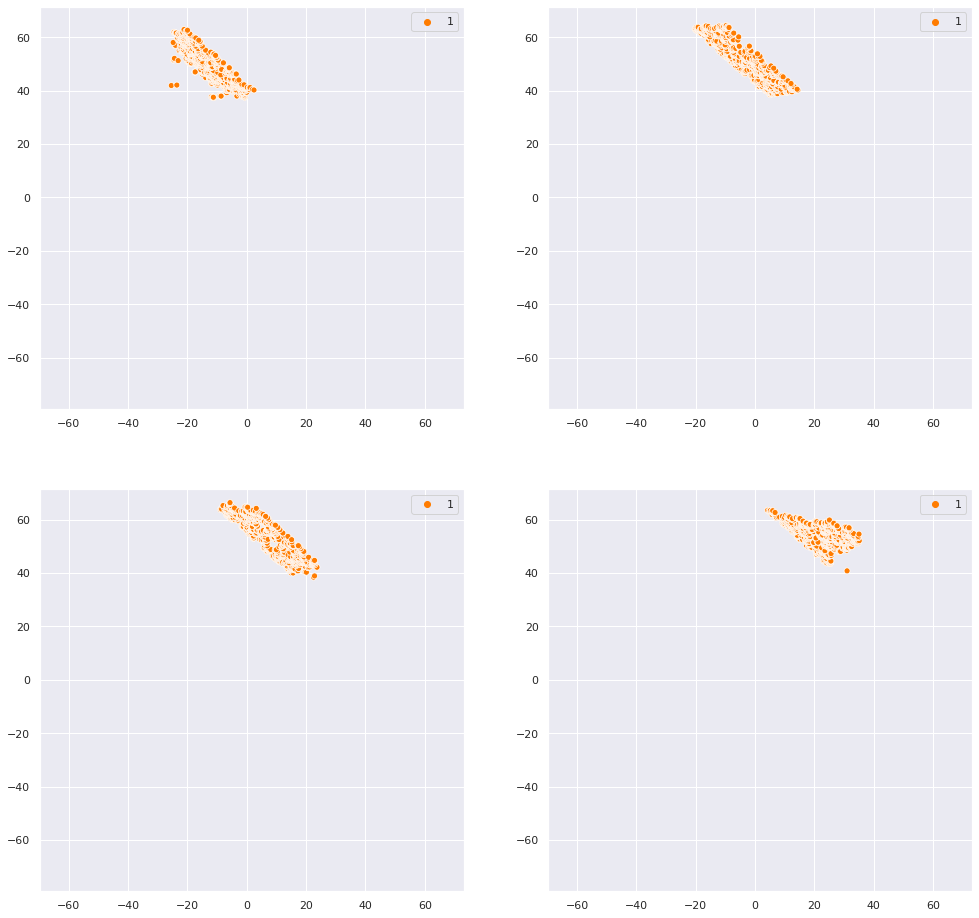

In [789]:
num_user = 4

sns.set(rc={'figure.figsize':(16.7,16.27)})

fig, axs = plt.subplots(nrows=num_user//2, ncols=2, )

user=0
for x in range(num_user // 2):
    for z in range(2):
        indexes = np.argsort(X_embedded_re2[:,0]+X_embedded_re2[:,1])
        indexes = indexes[user*(len(indexes)//num_user):(user+1)*(len(indexes)//num_user)]

        labels3 = np.squeeze([labels2[i] for i in indexes])
        X_embedded_re3 = [X_embedded_re2[i] for i in indexes]
        X_embedded_re3 = np.concatenate(X_embedded_re3, axis=0)
        X_embedded_re3 = np.reshape(X_embedded_re3, (X_embedded_re3.shape[0] // 2, 2))
        labels_unique = np.unique(labels3)
        palettes = [palette[i] for i in labels_unique]


        g = sns.scatterplot(X_embedded_re3[:,0], X_embedded_re3[:,1], hue=labels3, legend='full', palette=palettes, ax=axs[x][z])
        g.set(xlim=(x_min, x_max))
        g.set(ylim=(y_min, y_max))
        user+=1
        
sns.set(rc={'figure.figsize':(16.7,8.27)})
        

In [792]:
labels3=[]
X_embedded_re3=[]
user=0
for x in range(num_user // 2):
    for z in range(2):
        indexes = np.argsort(X_embedded_re2[:,0]+X_embedded_re2[:,1])
        indexes = indexes[user*(len(indexes)//num_user):(user+1)*(len(indexes)//num_user)]
        
        X_embedded_re3.append([X_embedded_re2[i] for i in indexes])
        
        
        labels3.append((np.squeeze([labels2[i] for i in indexes]))+user)
        user+=1

        
        
X_embedded_re3 = np.concatenate(X_embedded_re3, axis=0)
labels3 = np.concatenate(np.array(labels3))
while max(labels3) > 9:
    labels3 -= 1
labels_unique = np.unique(labels3)
palettes = [palette[i] for i in labels_unique]


[(-79.20205688476562, 71.37166595458984)]

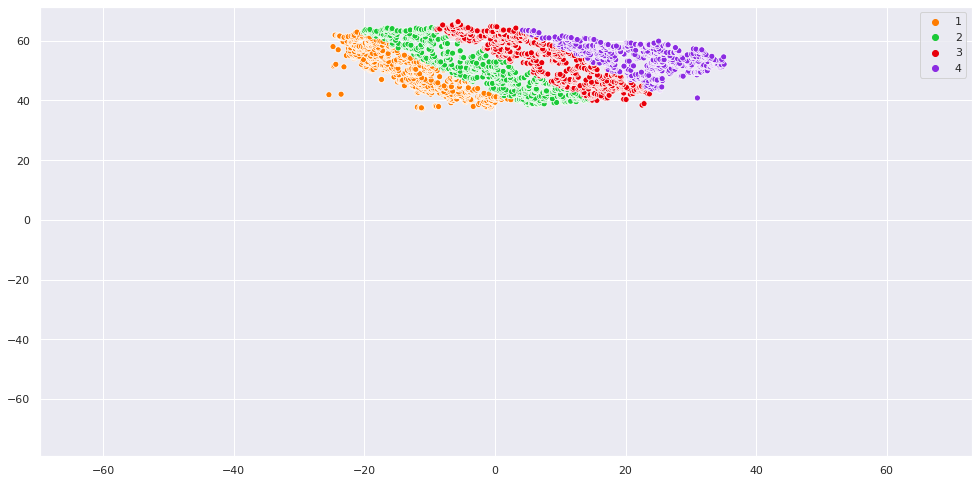

In [793]:
g = sns.scatterplot(X_embedded_re3[:,0], X_embedded_re3[:,1], hue=labels3, legend='full', palette=palettes)
g.set(xlim=(x_min, x_max))
g.set(ylim=(y_min, y_max))

# 2. Different Labels, Same Features

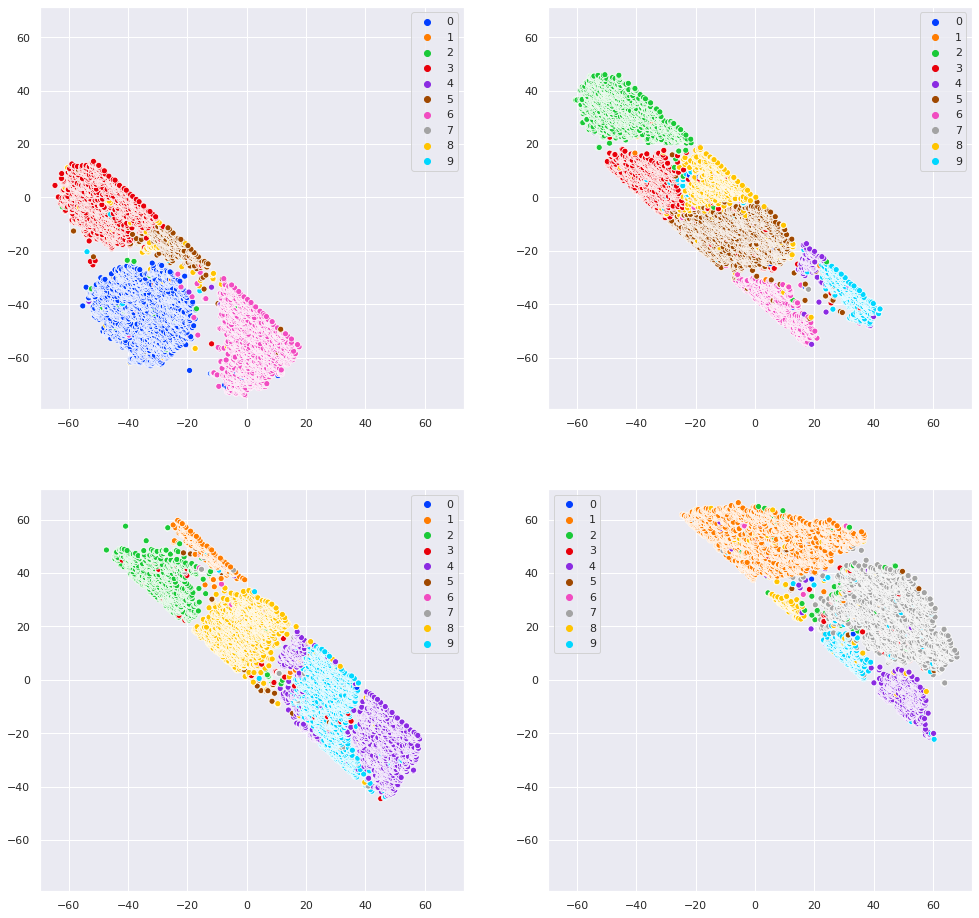

In [799]:
num_user = 4

sns.set(rc={'figure.figsize':(16.7,16.27)})

fig, axs = plt.subplots(nrows=num_user//2, ncols=2, )

user=0
for x in range(num_user // 2):
    for z in range(2):
        indexes = np.argsort(X_embedded[:,0]+X_embedded[:,1])
        indexes = indexes[user*(len(indexes)//num_user):(user+1)*(len(indexes)//num_user)]

        labels2 = np.squeeze([y[i] for i in indexes])
        X_embedded_re2 = [X_embedded[i] for i in indexes]
        X_embedded_re2 = np.concatenate(X_embedded_re2, axis=0)
        X_embedded_re2 = np.reshape(X_embedded_re2, (X_embedded_re2.shape[0] // 2, 2))
        labels_unique = np.unique(labels2)
        palettes = [palette[i] for i in labels_unique]


        g = sns.scatterplot(X_embedded_re2[:,0], X_embedded_re2[:,1], hue=labels2, legend='full', palette=palettes, ax=axs[x][z])
        g.set(xlim=(x_min, x_max))
        g.set(ylim=(y_min, y_max))
        user+=1
        
sns.set(rc={'figure.figsize':(16.7,8.27)})
        

In [796]:
labels3=[]
X_embedded_re3=[]
user=0
for x in range(num_user // 2):
    for z in range(2):
        indexes = np.argsort(X_embedded[:,0]+X_embedded[:,1])
        indexes = indexes[user*(len(indexes)//num_user):(user+1)*(len(indexes)//num_user)]
        
        X_embedded_re3.append([X_embedded[i] for i in indexes])
        
        
        labels3.append((np.squeeze([y[i] for i in indexes])) // 100 + user)
        user+=1

        
        
X_embedded_re3 = np.concatenate(X_embedded_re3, axis=0)
labels3 = np.concatenate(np.array(labels3))
while max(labels3) > 9:
    labels3 -= 1
labels_unique = np.unique(labels3)
palettes = [palette[i] for i in labels_unique]


[(-79.20205688476562, 71.37166595458984)]

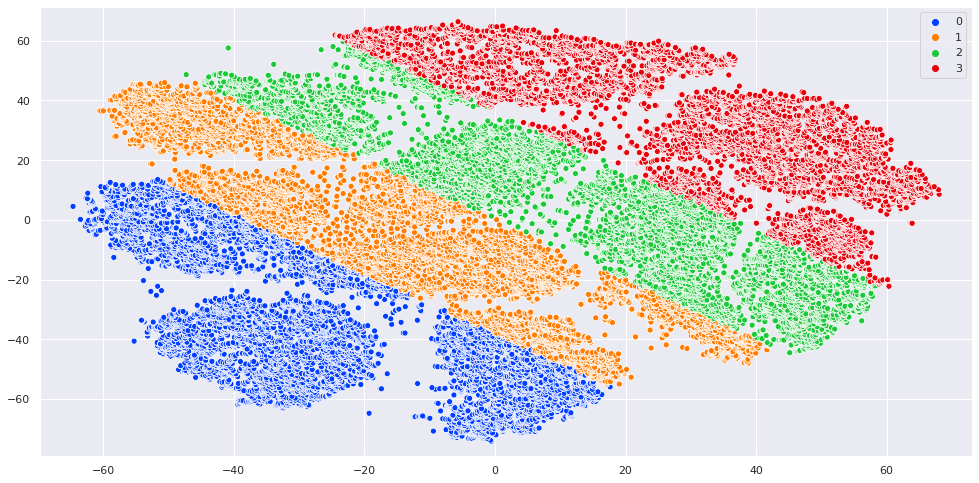

In [797]:
g = sns.scatterplot(X_embedded_re3[:,0], X_embedded_re3[:,1], hue=labels3, legend='full', palette=palettes)
g.set(xlim=(x_min, x_max))
g.set(ylim=(y_min, y_max))

In [ ]:
dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=None)
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)